# **Dataset Preperation and Preprocessing**


# `->` Install Dependencies

In [1]:
!pip install -q opendatasets transformers emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.4 MB/s eta 0:00:00


In [2]:
import opendatasets as od
import pandas as pd
from transformers import pipeline
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# stopwords
nltk.download('stopwords')
nltk.download('punkt')
# Download WordNet data
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# `->` Read Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
od.download('https://www.kaggle.com/datasets/thedevastator/amazon-product-reviews/data?select=train.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmdzghlul
Your Kaggle Key: ··········


100%|██████████| 667M/667M [00:38<00:00, 18.3MB/s]


In [ ]:
train_csv_file_path = "/content/amazon-product-reviews/test.csv"
df = pd.read_csv(train_csv_file_path)

In [ ]:
df

,label,title,content
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
...,...,...,...
399995,0,Unbelievable- In a Bad Way,We bought this Thomas for our son who is a hug...
399996,0,"Almost Great, Until it Broke...",My son recieved this as a birthday gift 2 mont...
399997,0,Disappointed !!!,"I bought this toy for my son who loves the ""Th..."
399998,1,Classic Jessica Mitford,This is a compilation of a wide range of Mitfo...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    400000 non-null  int64 
 1   title    399990 non-null  object
 2   content  400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


# `->` Extracting Emotions for reviews classification


Since we aim to build a multi-task model, we utilized `roberta-base-go_emotions`  for the emotion classification task so we could have another label besides the main binary one.

In [ ]:
# Import necessary classes from the transformers library
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --------------------------------------------------
# 1. Load the tokenizer for text preprocessing
# --------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
# This line loads a pre-trained tokenizer specifically designed for emotion classification tasks.
# It will be used to prepare text inputs for the model.

# --------------------------------------------------
# 2. Load the pre-trained model for emotion classification
# --------------------------------------------------
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
# This line loads a pre-trained model architecture and its weights,
# trained on the GoEmotions dataset for emotion classification.
# It will be used to process the tokenized text and predict emotions.


### Testing the pretrained model

In [ ]:
def analyze_advanced_emotion(text):
    # --------------------------------------------------
    # 1. Load the emotion analysis pipeline
    # --------------------------------------------------
    emotion_analyzer = pipeline("text-classification", model=model, tokenizer=tokenizer, top_k=None)
    # This line creates a pipeline for text classification tasks.
    # It combines the tokenizer and model for convenient use.
    # top_k=None is set to return all predicted emotions, not just the top few.

    # --------------------------------------------------
    # 2. Perform emotion analysis on the given text
    # --------------------------------------------------
    emotion_results = emotion_analyzer(text)
    # This line applies the pipeline to the input text,
    # generating emotion predictions and scores.
    print(emotion_results)  # Print the raw results for debugging

    # --------------------------------------------------
    # 3. Extract and format the results
    # --------------------------------------------------
    top_emotion = emotion_results[0][0]['label']  # Get the top predicted emotion label
    emotion_score = emotion_results[0][0]['score']  # Get the score for the top emotion

    return {
        "Top Emotion": top_emotion,  # Create a dictionary to organize the results
        "Emotion Score": emotion_score,
        "stars": top_emotion.split(" ")[0]  # Extract the first word for star rating (e.g., "joy" -> "joy")
    }

# --------------------------------------------------
# Example usage
# --------------------------------------------------
example_text = "I am so happy and satisfied with the service."
# Other examples:
# example_text = "not bad"
# example_text = "can be better"
# example_text = "very bad"

# Analyze the emotion
result = analyze_advanced_emotion(example_text)

# Print the results
print("Text:", example_text)
print(result)  # Print the formatted results
print("Top Emotion:", result["Top Emotion"])
print("Emotion Score:", result["Emotion Score"])


[[{'label': 'joy', 'score': 0.8904291391372681}, {'label': 'approval', 'score': 0.057502977550029755}, {'label': 'admiration', 'score': 0.05394122004508972}, {'label': 'relief', 'score': 0.03488766402006149}, {'label': 'neutral', 'score': 0.02577926404774189}, {'label': 'caring', 'score': 0.02524149976670742}, {'label': 'gratitude', 'score': 0.019507287070155144}, {'label': 'love', 'score': 0.018830275163054466}, {'label': 'excitement', 'score': 0.011979194357991219}, {'label': 'amusement', 'score': 0.010803252458572388}, {'label': 'optimism', 'score': 0.008762778714299202}, {'label': 'annoyance', 'score': 0.008746443316340446}, {'label': 'realization', 'score': 0.008166925050318241}, {'label': 'disapproval', 'score': 0.007608761079609394}, {'label': 'pride', 'score': 0.00741354376077652}, {'label': 'sadness', 'score': 0.005589516833424568}, {'label': 'anger', 'score': 0.0034953122958540916}, {'label': 'confusion', 'score': 0.003107829252257943}, {'label': 'desire', 'score': 0.00274016

### Apply emotions classification model on the Dataset

In [ ]:
# --------------------------------------------------
# 1. Load the emotion analysis pipeline
# --------------------------------------------------
emotion_analyzer = pipeline("text-classification", model=model, tokenizer=tokenizer)
# This line creates a pipeline that combines the pre-trained tokenizer and model,
# making it easier to perform emotion analysis on text inputs.

# --------------------------------------------------
# 2. Define a function to extract the top emotion from a review
# --------------------------------------------------
def get_emotion_for_review(text):
    # --------------------------------------------------
    # 2.1 Apply the pipeline to the review text
    # --------------------------------------------------
    emotion_results = emotion_analyzer(text)
    # This line uses the pipeline to analyze the text and generate emotion predictions.

    # --------------------------------------------------
    # 2.2 Extract and return the top emotion label
    # --------------------------------------------------
    return emotion_results[0]['label']  # This returns the label of the emotion with the highest predicted probability.


In [ ]:
# --------------------------------------------------
# 1. Create a smaller DataFrame with 10000 rows
# --------------------------------------------------
df2 = df.iloc[:10000]  # This line selects the first 10000 rows of the original DataFrame.

# --------------------------------------------------
# 2. Add a new column for predicted emotions
# --------------------------------------------------
df2["emotion"] = (df2["title"] + " " + df2["content"]).apply(get_emotion_for_review)
# This line does the following:
# - Concatenates the "title" and "content" columns to create a combined text.
# - Applies the `get_emotion_for_review` function to each combined text, extracting the top emotion.
# - Stores the predicted emotions in a new column named "emotion".

# --------------------------------------------------
# 3. View the top 5 rows of the updated DataFrame
# --------------------------------------------------
df2.head()  # This displays the first 5 rows of df2, including the new "emotion" column.


<ipython-input-12-6b8653664755>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["emotion"] = (df2["title"] + " " +  df2["content"]).apply(get_emotion_for_review)


,label,title,content,emotion
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,admiration
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,admiration
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,neutral
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,neutral
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,disapproval


In [ ]:
# --------------------------------------------------
# Specify the path to save the CSV file
# --------------------------------------------------
csv_file_path = '/content/drive/MyDrive/amazon-product-reviews/data_with_emotions3.csv'
# This line defines the location where the CSV file will be saved.

# --------------------------------------------------
# Save the DataFrame to a CSV file
# --------------------------------------------------
df2.to_csv(csv_file_path, index=False)
# This line does the following:
# - Calls the `to_csv` method on the DataFrame `df2` to save it as a CSV file.
# - Uses the specified `csv_file_path` as the output location.
# - Sets `index=False` to prevent saving the row indices in the CSV file.


In [ ]:
data_with_emotions3 = pd.read_csv('/content/drive/MyDrive/Career/Master/ML/amazon-product-reviews/data_with_emotions3.csv')
data_with_emotions3.head()

,label,title,content,emotion
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,admiration
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,admiration
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,neutral
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,neutral
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,disapproval


# `->` Data Preprocesing

## Check missing Values

In [ ]:
df.isnull().sum()

label       0
title      10
content     0
dtype: int64

## Handling Missing Values

In [ ]:
# Nulls values are so small, so we can drop them
df.dropna(subset=['title'], inplace=True)

## Text Cleaning

In [ ]:
# --------------------------------------------------
# Import necessary libraries
# --------------------------------------------------
import re  # Regular expressions for pattern matching
import string  # For punctuation handling
from textblob import TextBlob  # For spell correction

# --------------------------------------------------
# Text cleaning helper functions
# --------------------------------------------------

def remove_mentions(input_text):
    """Removes mentions of other users (e.g., "@username") from the text.

    Args:
        input_text (str): The text to be cleaned.

    Returns:
        str: The text with mentions removed.
    """
    return re.sub(r'@\w+', '', input_text)

def remove_urls(input_text):
    """Removes URLs from the text.

    Args:
        input_text (str): The text to be cleaned.

    Returns:
        str: The text with URLs removed.
    """
    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

def emoji_oneword(input_text):
    """Collapses multi-character emojis into single words by removing underscores and colons.

    Args:
        input_text (str): The text to be cleaned.

    Returns:
        str: The text with condensed emojis.
    """
    # By compressing the underscore, the emoji is kept as one word
    return input_text.replace('_','').replace(':','')

def remove_punctuation(input_text):
    """Removes punctuation from the text.

    Args:
        input_text (str): The text to be cleaned.

    Returns:
        str: The text without punctuation.
    """
    # Make translation table
    punct = string.punctuation
    # Every punctuation symbol will be replaced by a space
    trantab = str.maketrans(punct, len(punct)*' ')
    return input_text.translate(trantab)

def remove_digits(input_text):
    """Removes digits from the text.

    Args:
        input_text (str): The text to be cleaned.

    Returns:
        str: The text without digits.
    """
    return re.sub('\d+', '', input_text)

def to_lower(input_text):
    """Converts all text to lowercase.

    Args:
        input_text (str): The text to be converted.

    Returns:
        str: The text in lowercase.
    """
    return input_text.lower()

def remove_non_ascii(input_text):
    """Removes non-ASCII characters from the text.

    Args:
        input_text (str): The text to be cleaned.

    Returns:
        str: The text containing only ASCII characters.
    """
    return re.sub(r'[^\x00-\x7f]',r'', input_text)

def spellingorrection(input_text):
    """Corrects spelling errors in the text using TextBlob.

    Args:
        input_text (str): The text to be corrected.

    Returns:
        str: The text with corrected spelling.
    """
    return TextBlob(input_text).correct()


In [ ]:
def clean_text(dataset, text_field, new_text_field_name):
    """Cleans text data in a DataFrame using a series of cleaning functions.

    Args:
        dataset (pandas.DataFrame): The DataFrame containing the text data.
        text_field (str): The name of the column containing the text to be cleaned.
        new_text_field_name (str): The name of the new column to store the cleaned text.

    Returns:
        pandas.DataFrame: The DataFrame with the cleaned text in the new column.
    """

    # Create a new column for the cleaned text
    dataset[new_text_field_name] = dataset[text_field]

    # Apply cleaning functions sequentially
    # -----------------------------------

    # Remove mentions of other users (e.g., "@username")
    dataset[new_text_field_name] = dataset[new_text_field_name].apply(remove_mentions)

    # Remove URLs
    dataset[new_text_field_name] = dataset[new_text_field_name].apply(remove_urls)

    # Collapse multi-character emojis into single words
    dataset[new_text_field_name] = dataset[new_text_field_name].apply(emoji_oneword)

    # Remove punctuation
    dataset[new_text_field_name] = dataset[new_text_field_name].apply(remove_punctuation)

    # Remove digits
    dataset[new_text_field_name] = dataset[new_text_field_name].apply(remove_digits)

    # Convert text to lowercase
    dataset[new_text_field_name] = dataset[new_text_field_name].apply(to_lower)

    # Remove non-ASCII characters
    dataset[new_text_field_name] = dataset[new_text_field_name].apply(remove_non_ascii)

    # Optionally apply spelling correction (commented out for potential performance reasons)
    # dataset[new_text_field_name] = dataset[new_text_field_name].apply(spelling_correction)

    return dataset  # Return the DataFrame with the cleaned text


In [ ]:
df_clean = clean_text(df2, 'title', 'clean_title')

df_clean = clean_text(df2, 'content', 'clean_content')

df_clean.head()

<ipython-input-15-ad1c06a73e10>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[new_text_field_name] = dataset[text_field].apply(remove_mentions)
<ipython-input-15-ad1c06a73e10>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[new_text_field_name] = dataset[new_text_field_name].apply(remove_urls)
<ipython-input-15-ad1c06a73e10>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,label,title,content,emotion,clean_title,clean_content
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,admiration,great cd,my lovely pat has one of the great voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,admiration,one of the best game music soundtracks for a...,despite the fact that i have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,neutral,batteries died within a year,i bought this charger in jul and it worked ok...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,neutral,works fine but maha energy is better,check out maha energy s website their powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,disapproval,great for the non audiophile,reviewed quite a bit of the combo players and ...


## Handling Stopwords

In [ ]:

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(input_text):
    """Removes stop words from text while preserving certain sentiment-bearing words.

    Args:
        input_text (str): The text to be processed.

    Returns:
        str: The text with stop words removed, preserving specified words.
    """

    # Load a list of common English stop words
    stopwords_list = stopwords.words('english')

    # Create a whitelist of words to keep despite being stop words
    whitelist = ["n't", "not", "no"]  # These words can convey sentiment

    # Split the text into individual words
    words = input_text.split()

    # Filter the words:
    clean_words = [
        word for word in words
        if (word not in stopwords_list or word in whitelist) and len(word) > 1
    ]

    # Retain only words that are not in the stopwords list or are in the whitelist,
    # and also ensure words are longer than 1 character to avoid noise.

    # Join the filtered words back into a string
    return " ".join(clean_words)


In [ ]:
# Remove stop words
df_clean['clean_title_without_stopwords'] = df_clean['clean_title'].apply(remove_stopwords)
df_clean['clean_content_without_stopwords'] = df_clean['clean_content'].apply(remove_stopwords)


<ipython-input-19-56bea61b1907>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['clean_title_without_stopwords'] = df_clean['clean_title'].apply(remove_stopwords)
<ipython-input-19-56bea61b1907>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['clean_content_without_stopwords'] = df_clean['clean_content'].apply(remove_stopwords)


In [ ]:
df_clean.head()

,label,title,content,emotion,clean_title,clean_content,clean_title_without_stopwords,clean_content_without_stopwords
10001,1,Best purchase ever!!!!,We bought this exersaucer when our little guy ...,admiration,best purchase ever,we bought this exersaucer when our little guy ...,best purchase ever,bought exersaucer little guy barely able sit u...
10002,1,Keep them entertained!,I bought this for my grandaughter when she was...,admiration,keep them entertained,i bought this for my grandaughter when she was...,keep entertained,bought grandaughter months old learned turn se...
10003,0,"IMPOSSIBLE to clean.. paint chpped, unsanitary",Why in the world would you make a toy for babi...,approval,impossible to clean paint chpped unsanitary,why in the world would you make a toy for babi...,impossible clean paint chpped unsanitary,world would make toy babies slobber impossible...
10004,1,A classic 'pop' album!,East 17 are quite easily the best pop ever. Fo...,admiration,a classic pop album,east are quite easily the best pop ever forg...,classic pop album,east quite easily best pop ever forget backstr...
10005,0,The Spontantous Fulfillment of Desire,I didn't care for the method of presentation. ...,surprise,the spontantous fulfillment of desire,i didn t care for the method of presentation ...,spontantous fulfillment desire,care method presentation monotone felt like wo...


## Tokenization

In [ ]:
# --------------------------------------------------
# Tokenize title and content text
# --------------------------------------------------

df_clean['title_tokens'] = df_clean['clean_title_without_stopwords'].apply(lambda x: word_tokenize(x))
# This line does the following:
# - Applies the `word_tokenize` function to each text in the 'clean_title_without_stopwords' column.
# - The `word_tokenize` function splits a string into a list of words (tokens).
# - Stores the resulting lists of tokens in a new column named 'title_tokens'.

df_clean['content_tokens'] = df_clean['clean_content_without_stopwords'].apply(lambda x: word_tokenize(x))
# This line does the same as above, but for the 'clean_content_without_stopwords' column.

# --------------------------------------------------
# View the DataFrame
# --------------------------------------------------

df_clean.head()  # This displays the first 5 rows of the DataFrame, including the newly added tokenized columns.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-20-1af63c3cedd4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['title_tokens'] = df_clean['clean_title_without_stopwords'].apply(lambda x: word_tokenize(x))
<ipython-input-20-1af63c3cedd4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['content_tokens'] = df_clean['clean_content_without_stopwords'].apply(lambda x: word_tokenize(x))


,label,title,content,emotion,clean_title,clean_content,clean_title_without_stopwords,clean_content_without_stopwords,title_tokens,content_tokens
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,admiration,great cd,my lovely pat has one of the great voices of h...,great cd,lovely pat one great voices generation listene...,"[great, cd]","[lovely, pat, one, great, voices, generation, ..."
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,admiration,one of the best game music soundtracks for a...,despite the fact that i have only played a sma...,one best game music soundtracks game really play,despite fact played small portion game music h...,"[one, best, game, music, soundtracks, game, re...","[despite, fact, played, small, portion, game, ..."
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,neutral,batteries died within a year,i bought this charger in jul and it worked ok...,batteries died within year,bought charger jul worked ok design nice conve...,"[batteries, died, within, year]","[bought, charger, jul, worked, ok, design, nic..."
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,neutral,works fine but maha energy is better,check out maha energy s website their powerex...,works fine maha energy better,check maha energy website powerex mh cf charge...,"[works, fine, maha, energy, better]","[check, maha, energy, website, powerex, mh, cf..."
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,disapproval,great for the non audiophile,reviewed quite a bit of the combo players and ...,great non audiophile,reviewed quite bit combo players hesitant due ...,"[great, non, audiophile]","[reviewed, quite, bit, combo, players, hesitan..."


## Stemming  Text

In [ ]:
def apply_stemming(tokens):
    """Applies stemming to a list of tokens using the PorterStemmer algorithm.

    Args:
        tokens (list): A list of words (tokens) to be stemmed.

    Returns:
        list: A list of stemmed tokens.
    """

    # Create a PorterStemmer object for English stemming
    porter = PorterStemmer()

    # Stem each token in the input list
    stemmed_tokens = [porter.stem(token) for token in tokens]

    # Return the list of stemmed tokens
    return stemmed_tokens


In [ ]:
# --------------------------------------------------
# Apply stemming to tokenized text
# --------------------------------------------------

# Apply stemming to the 'title_tokens' column and store the results in 'stemmed_title_tokens'
df_clean['stemmed_title_tokens'] = df_clean['title_tokens'].apply(apply_stemming)

# Apply stemming to the 'content_tokens' column and store the results in 'stemmed_content_tokens'
df_clean['stemmed_content_tokens'] = df_clean['content_tokens'].apply(apply_stemming)


<ipython-input-22-f60a11fa4a9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['stemmed_title_tokens'] = df_clean['title_tokens'].apply(apply_stemming)
<ipython-input-22-f60a11fa4a9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['stemmed_content_tokens'] = df_clean['content_tokens'].apply(apply_stemming)


In [ ]:
df_clean.head()

,label,title,content,emotion,clean_title,clean_content,clean_title_without_stopwords,clean_content_without_stopwords,title_tokens,content_tokens,stemmed_title_tokens,stemmed_content_tokens
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,admiration,great cd,my lovely pat has one of the great voices of h...,great cd,lovely pat one great voices generation listene...,"[great, cd]","[lovely, pat, one, great, voices, generation, ...","[great, cd]","[love, pat, one, great, voic, gener, listen, c..."
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,admiration,one of the best game music soundtracks for a...,despite the fact that i have only played a sma...,one best game music soundtracks game really play,despite fact played small portion game music h...,"[one, best, game, music, soundtracks, game, re...","[despite, fact, played, small, portion, game, ...","[one, best, game, music, soundtrack, game, rea...","[despit, fact, play, small, portion, game, mus..."
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,neutral,batteries died within a year,i bought this charger in jul and it worked ok...,batteries died within year,bought charger jul worked ok design nice conve...,"[batteries, died, within, year]","[bought, charger, jul, worked, ok, design, nic...","[batteri, die, within, year]","[bought, charger, jul, work, ok, design, nice,..."
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,neutral,works fine but maha energy is better,check out maha energy s website their powerex...,works fine maha energy better,check maha energy website powerex mh cf charge...,"[works, fine, maha, energy, better]","[check, maha, energy, website, powerex, mh, cf...","[work, fine, maha, energi, better]","[check, maha, energi, websit, powerex, mh, cf,..."
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,disapproval,great for the non audiophile,reviewed quite a bit of the combo players and ...,great non audiophile,reviewed quite bit combo players hesitant due ...,"[great, non, audiophile]","[reviewed, quite, bit, combo, players, hesitan...","[great, non, audiophil]","[review, quit, bit, combo, player, hesit, due,..."


## Lemmatization Text

In [ ]:
# --------------------------------------------------
# Lemmatization
# --------------------------------------------------

# Create an instance of WordNetLemmatizer for English language lemmatization
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a text string
def lemmatize_text(text):
    """Lemmatizes a string of text using WordNetLemmatizer.

    Args:
        text (str): The text string to be lemmatized.

    Returns:
        str: The lemmatized text string.
    """

    # Lemmatize each word in the text and join them back into a string
    return ' '.join([lemmatizer.lemmatize(word) for word in text])

# --------------------------------------------------
# Apply lemmatization to the tokenized text columns
# --------------------------------------------------

# Apply lemmatization to the 'title_tokens' column and store the results in 'lemmatized_title'
df_clean['lemmatized_title'] = df_clean['title_tokens'].apply(lemmatize_text)

# Apply lemmatization to the 'content_tokens' column and store the results in 'lemmatized_content'
df_clean['lemmatized_content'] = df_clean['content_tokens'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-23-983aea16a1cc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['lemmatized_title'] = df_clean['title_tokens'].apply(lemmatize_text)
<ipython-input-23-983aea16a1cc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['lemmatized_content'] = df_clean['content_tokens'].apply(lemmatize_text)


In [ ]:
# --------------------------------------------------
# Convert stemmed tokens back to text strings
# --------------------------------------------------

# Join the stemmed tokens in the 'stemmed_title_tokens' column back into strings,
# creating a new column named 'cleaned_title_text'
df_clean['cleaned_title_text'] = df_clean['stemmed_title_tokens'].apply(lambda tokens: ' '.join(tokens))

# Apply the same process to the 'stemmed_content_tokens' column,
# creating a new column named 'cleaned_content_text'
df_clean['cleaned_content_text'] = df_clean['stemmed_content_tokens'].apply(lambda tokens: ' '.join(tokens))


<ipython-input-24-74bd8c106f34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cleaned_title_text'] = df_clean['stemmed_title_tokens'].apply(lambda tokens: ' '.join(tokens))
<ipython-input-24-74bd8c106f34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cleaned_content_text'] = df_clean['stemmed_content_tokens'].apply(lambda tokens: ' '.join(tokens))


In [ ]:
# --------------------------------------------------
# Combine title and content text
# --------------------------------------------------

# Create a new column named 'final_text' by concatenating the 'cleaned_title_text'
# and 'cleaned_content_text' columns, effectively merging the processed title and content
df_clean['final_text'] = df_clean['cleaned_title_text'] + df_clean['cleaned_content_text']


<ipython-input-25-09832f849c0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['final_text'] = df_clean['cleaned_title_text'] + df_clean['cleaned_content_text']


In [ ]:
df_clean.head()

,label,title,content,emotion,clean_title,clean_content,clean_title_without_stopwords,clean_content_without_stopwords,title_tokens,content_tokens,stemmed_title_tokens,stemmed_content_tokens,lemmatized_title,lemmatized_content,cleaned_title_text,cleaned_content_text,final_text
10001,1,Best purchase ever!!!!,We bought this exersaucer when our little guy ...,admiration,best purchase ever,we bought this exersaucer when our little guy ...,best purchase ever,bought exersaucer little guy barely able sit u...,"[best, purchase, ever]","[bought, exersaucer, little, guy, barely, able...","[best, purchas, ever]","[bought, exersauc, littl, guy, bare, abl, sit,...",best purchase ever,bought exersaucer little guy barely able sit u...,best purchas ever,bought exersauc littl guy bare abl sit upright...,best purchas everbought exersauc littl guy bar...
10002,1,Keep them entertained!,I bought this for my grandaughter when she was...,admiration,keep them entertained,i bought this for my grandaughter when she was...,keep entertained,bought grandaughter months old learned turn se...,"[keep, entertained]","[bought, grandaughter, months, old, learned, t...","[keep, entertain]","[bought, grandaught, month, old, learn, turn, ...",keep entertained,bought grandaughter month old learned turn sea...,keep entertain,bought grandaught month old learn turn seat re...,keep entertainbought grandaught month old lear...
10003,0,"IMPOSSIBLE to clean.. paint chpped, unsanitary",Why in the world would you make a toy for babi...,approval,impossible to clean paint chpped unsanitary,why in the world would you make a toy for babi...,impossible clean paint chpped unsanitary,world would make toy babies slobber impossible...,"[impossible, clean, paint, chpped, unsanitary]","[world, would, make, toy, babies, slobber, imp...","[imposs, clean, paint, chpped, unsanitari]","[world, would, make, toy, babi, slobber, impos...",impossible clean paint chpped unsanitary,world would make toy baby slobber impossible c...,imposs clean paint chpped unsanitari,world would make toy babi slobber imposs clean...,imposs clean paint chpped unsanitariworld woul...
10004,1,A classic 'pop' album!,East 17 are quite easily the best pop ever. Fo...,admiration,a classic pop album,east are quite easily the best pop ever forg...,classic pop album,east quite easily best pop ever forget backstr...,"[classic, pop, album]","[east, quite, easily, best, pop, ever, forget,...","[classic, pop, album]","[east, quit, easili, best, pop, ever, forget, ...",classic pop album,east quite easily best pop ever forget backstr...,classic pop album,east quit easili best pop ever forget backstre...,classic pop albumeast quit easili best pop eve...
10005,0,The Spontantous Fulfillment of Desire,I didn't care for the method of presentation. ...,surprise,the spontantous fulfillment of desire,i didn t care for the method of presentation ...,spontantous fulfillment desire,care method presentation monotone felt like wo...,"[spontantous, fulfillment, desire]","[care, method, presentation, monotone, felt, l...","[spontant, fulfil, desir]","[care, method, present, monoton, felt, like, w...",spontantous fulfillment desire,care method presentation monotone felt like wo...,spontant fulfil desir,care method present monoton felt like work har...,spontant fulfil desircare method present monot...


In [ ]:
# Save df after all cleaning
csv_file_path = '/content/drive/MyDrive/amazon-product-reviews/data_after_cleaning3.csv'
df_clean.to_csv(csv_file_path, index=False)

In [ ]:
data_after_cleaning3 = pd.read_csv('/content/drive/MyDrive/Career/Master/ML/amazon-product-reviews/data_after_cleaning3.csv')
data_after_cleaning3.head()

,label,title,content,emotion,clean_title,clean_content,clean_title_without_stopwords,clean_content_without_stopwords,title_tokens,content_tokens,stemmed_title_tokens,stemmed_content_tokens,lemmatized_title,lemmatized_content,cleaned_title_text,cleaned_content_text,final_text
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,admiration,great cd,my lovely pat has one of the great voices of h...,great cd,lovely pat one great voices generation listene...,"['great', 'cd']","['lovely', 'pat', 'one', 'great', 'voices', 'g...","['great', 'cd']","['love', 'pat', 'one', 'great', 'voic', 'gener...",great cd,lovely pat one great voice generation listened...,great cd,love pat one great voic gener listen cd year s...,great cdlove pat one great voic gener listen c...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,admiration,one of the best game music soundtracks for a...,despite the fact that i have only played a sma...,one best game music soundtracks game really play,despite fact played small portion game music h...,"['one', 'best', 'game', 'music', 'soundtracks'...","['despite', 'fact', 'played', 'small', 'portio...","['one', 'best', 'game', 'music', 'soundtrack',...","['despit', 'fact', 'play', 'small', 'portion',...",one best game music soundtrack game really play,despite fact played small portion game music h...,one best game music soundtrack game realli play,despit fact play small portion game music hear...,one best game music soundtrack game realli pla...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,neutral,batteries died within a year,i bought this charger in jul and it worked ok...,batteries died within year,bought charger jul worked ok design nice conve...,"['batteries', 'died', 'within', 'year']","['bought', 'charger', 'jul', 'worked', 'ok', '...","['batteri', 'die', 'within', 'year']","['bought', 'charger', 'jul', 'work', 'ok', 'de...",battery died within year,bought charger jul worked ok design nice conve...,batteri die within year,bought charger jul work ok design nice conveni...,batteri die within yearbought charger jul work...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,neutral,works fine but maha energy is better,check out maha energy s website their powerex...,works fine maha energy better,check maha energy website powerex mh cf charge...,"['works', 'fine', 'maha', 'energy', 'better']","['check', 'maha', 'energy', 'website', 'powere...","['work', 'fine', 'maha', 'energi', 'better']","['check', 'maha', 'energi', 'websit', 'powerex...",work fine maha energy better,check maha energy website powerex mh cf charge...,work fine maha energi better,check maha energi websit powerex mh cf charger...,work fine maha energi bettercheck maha energi ...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,disapproval,great for the non audiophile,reviewed quite a bit of the combo players and ...,great non audiophile,reviewed quite bit combo players hesitant due ...,"['great', 'non', 'audiophile']","['reviewed', 'quite', 'bit', 'combo', 'players...","['great', 'non', 'audiophil']","['review', 'quit', 'bit', 'combo', 'player', '...",great non audiophile,reviewed quite bit combo player hesitant due u...,great non audiophil,review quit bit combo player hesit due unfavor...,great non audiophilreview quit bit combo playe...


# `->` Sub-Classes EDA



In [5]:
data_after_cleaning2 = pd.read_csv('/content/drive/MyDrive/amazon-product-reviews/data_after_cleaning2.csv')
# filtered_data = ""
# Concatenate the DataFrames along the rows
data_after_cleaning = pd.concat([data_after_cleaning2, data_after_cleaning3], axis=0, ignore_index=True)

# Drop rows with null values in both DataFrames
data_after_cleaning.dropna(axis=0, inplace=True)

# Optionally, print the shapes of the merged DataFrames
print("data_after_cleaning shape:", data_after_cleaning.shape)
data_after_cleaning.head(2)

data_after_cleaning shape: (19898, 17)


,label,title,content,emotion,clean_title,clean_content,clean_title_without_stopwords,clean_content_without_stopwords,title_tokens,content_tokens,stemmed_title_tokens,stemmed_content_tokens,lemmatized_title,lemmatized_content,cleaned_title_text,cleaned_content_text,final_text
0,1,Best purchase ever!!!!,We bought this exersaucer when our little guy ...,admiration,best purchase ever,we bought this exersaucer when our little guy ...,best purchase ever,bought exersaucer little guy barely able sit u...,"['best', 'purchase', 'ever']","['bought', 'exersaucer', 'little', 'guy', 'bar...","['best', 'purchas', 'ever']","['bought', 'exersauc', 'littl', 'guy', 'bare',...",best purchase ever,bought exersaucer little guy barely able sit u...,best purchas ever,bought exersauc littl guy bare abl sit upright...,best purchas everbought exersauc littl guy bar...
1,1,Keep them entertained!,I bought this for my grandaughter when she was...,admiration,keep them entertained,i bought this for my grandaughter when she was...,keep entertained,bought grandaughter months old learned turn se...,"['keep', 'entertained']","['bought', 'grandaughter', 'months', 'old', 'l...","['keep', 'entertain']","['bought', 'grandaught', 'month', 'old', 'lear...",keep entertained,bought grandaughter month old learned turn sea...,keep entertain,bought grandaught month old learn turn seat re...,keep entertainbought grandaught month old lear...


## Check Imbalance

admiration        6655
disappointment    2828
neutral           2642
disapproval       1387
love               992
annoyance          956
approval           899
joy                758
amusement          341
confusion          308
gratitude          287
disgust            247
curiosity          233
sadness            198
optimism           195
desire             169
fear               166
surprise           147
remorse            124
excitement         110
realization        100
caring              63
anger               52
embarrassment       40
nervousness          1
Name: emotion, dtype: int64


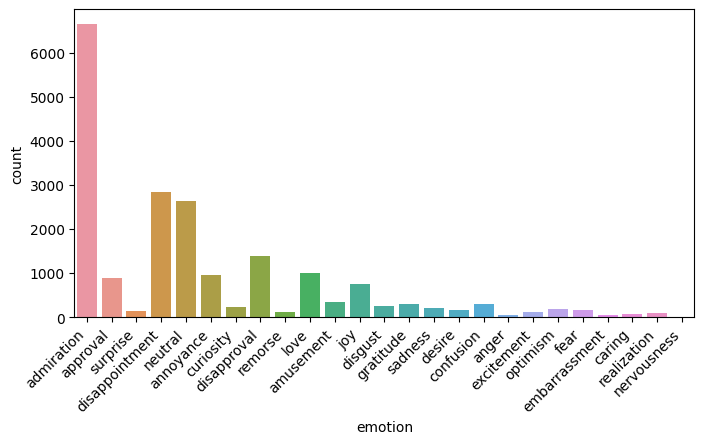

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x=data_after_cleaning['emotion'], ax=ax)
plt.xticks(rotation=45, ha="right")

print(data_after_cleaning['emotion'].value_counts())
plt.show()


## Handle Imbalance a little bit

In [9]:
# Filter out rows with emotion counts less than 200
emotion_counts = data_after_cleaning['emotion'].value_counts()
emotions_to_keep = emotion_counts[emotion_counts >= 200].index

# Create a new DataFrame with only the rows where emotion is in emotions_to_keep
filtered_data = data_after_cleaning[data_after_cleaning['emotion'].isin(emotions_to_keep)]
filtered_data.head(2)


,label,title,content,emotion,clean_title,clean_content,clean_title_without_stopwords,clean_content_without_stopwords,title_tokens,content_tokens,stemmed_title_tokens,stemmed_content_tokens,lemmatized_title,lemmatized_content,cleaned_title_text,cleaned_content_text,final_text
0,1,Best purchase ever!!!!,We bought this exersaucer when our little guy ...,admiration,best purchase ever,we bought this exersaucer when our little guy ...,best purchase ever,bought exersaucer little guy barely able sit u...,"['best', 'purchase', 'ever']","['bought', 'exersaucer', 'little', 'guy', 'bar...","['best', 'purchas', 'ever']","['bought', 'exersauc', 'littl', 'guy', 'bare',...",best purchase ever,bought exersaucer little guy barely able sit u...,best purchas ever,bought exersauc littl guy bare abl sit upright...,best purchas everbought exersauc littl guy bar...
1,1,Keep them entertained!,I bought this for my grandaughter when she was...,admiration,keep them entertained,i bought this for my grandaughter when she was...,keep entertained,bought grandaughter months old learned turn se...,"['keep', 'entertained']","['bought', 'grandaughter', 'months', 'old', 'l...","['keep', 'entertain']","['bought', 'grandaught', 'month', 'old', 'lear...",keep entertained,bought grandaughter month old learned turn sea...,keep entertain,bought grandaught month old learn turn seat re...,keep entertainbought grandaught month old lear...


<ipython-input-10-d004c1bd4bd3>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data[filtered_data['emotion'] != 'admiration'].append(admiration_data)


admiration        3000
disappointment    2828
neutral           2642
disapproval       1387
love               992
annoyance          956
approval           899
joy                758
amusement          341
confusion          308
gratitude          287
disgust            247
curiosity          233
Name: emotion, dtype: int64


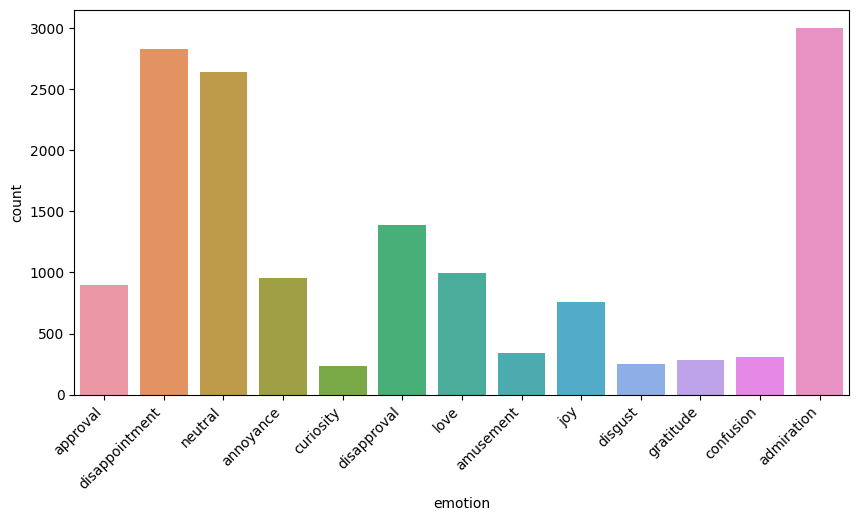

In [10]:
# Downsample 'admiration' label to the target count
admiration_data = filtered_data[filtered_data['emotion'] == 'admiration'].sample(n=3000, replace=True, random_state=42)

# Remove extra rows of 'admiration' label from the filtered data
filtered_data = filtered_data[filtered_data['emotion'] != 'admiration'].append(admiration_data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='emotion', data=filtered_data, ax=ax)
plt.xticks(rotation=45, ha="right")  # You can adjust the rotation angle as needed
print(filtered_data['emotion'].value_counts())
plt.show()

In [12]:
filtered_data[['cleaned_title_text', 'cleaned_content_text', 'label', 'emotion']].to_csv("Finaldata.csv", index=False)

## Explore Emotion Classes World-Cloud

Here we were trying to find the common classes manually, but it wasn't that clear. However, it looks cool, so we left it here for general exploration if someone wants.

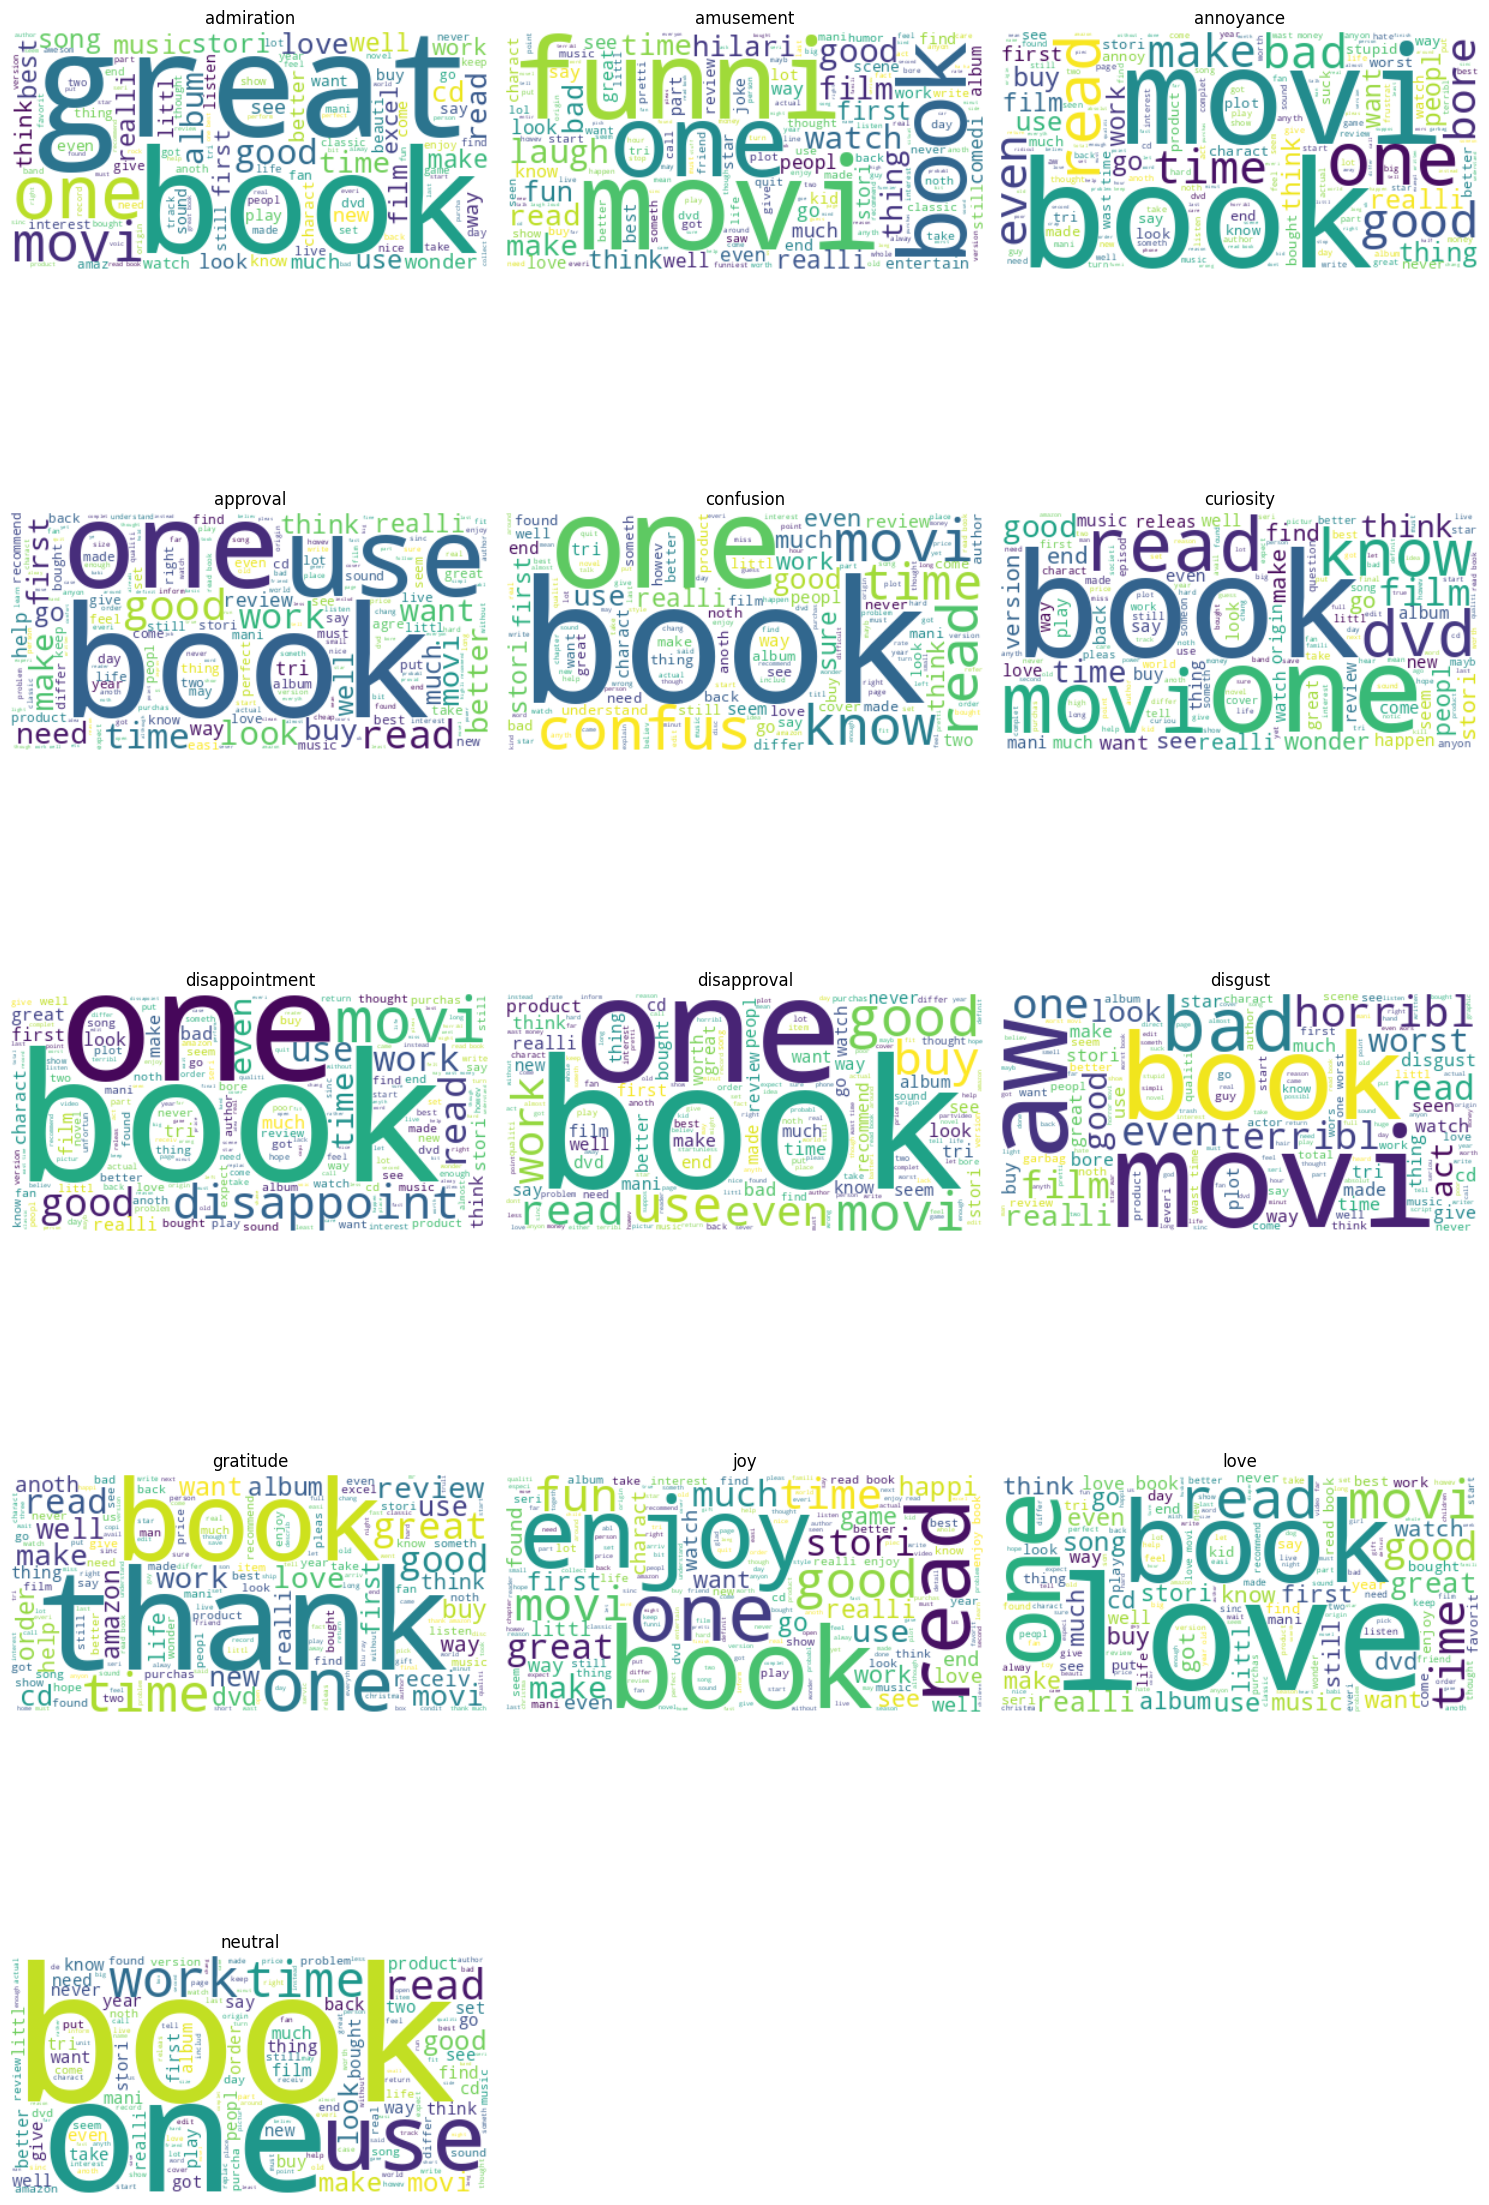

In [ ]:
from wordcloud import WordCloud
# Function to generate word cloud for each class and plot in subplots
def generate_word_cloud_subplot(text, title, ax):
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)

    # Plot the Word Cloud in a subplot
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

# Group by 'emotion' and generate word clouds for each group
grouped_df = filtered_data.groupby('emotion')

# Set up subplots
num_classes = len(grouped_df)
num_subplots_per_row = 3
num_rows = -(-num_classes // num_subplots_per_row)  # Ceiling division to calculate the number of rows

fig, axes = plt.subplots(num_rows, num_subplots_per_row, figsize=(15, 5 * num_rows))

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Iterate through groups and plot word clouds
for idx, (emotion_label, group) in enumerate(grouped_df):
    emotion_text = ' '.join(group['X'].astype(str))
    generate_word_cloud_subplot(emotion_text, f"{emotion_label}", axes[idx])

# Remove empty subplots if needed
for i in range(num_classes, num_rows * num_subplots_per_row):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# This was the EDA and Preprocessing Part, Still not done yet...
 ___

Now since we have a lot of emotion classes and the data is so imbalanced,

We had the idea of merging similar emotion theories as a way of decreasing the dimentionality and enhancing the imbalance.

On the other Notebook We will go through a model comparison and also a data comparison to see if this idea will be a good one.